# EVAL Problem 1
In this EVAL problem, we will study the behavior of the system when multiple processors (a.k.a. threads in this case) are available to process the incoming workload. For this part, make sure to have at least $w$+2 processors available in your system, where $w$ is the number of worker threads that we will start. The extra two threads are needed for the client and the parent thread, respectively.

In [107]:
# Import Packages
import re
from collections import defaultdict
import math
import matplotlib.pyplot as plt

-----
a) First thing first, determine the maximum number of CPUs that you can use for this EVAL problem. If your machine has $w$ + 2 = 4 CPUs, you should consider $w$ = 2, and so on. For this part, simply explain how you recovered that information for your machine. If you are using SCC, you can select required number of CPUs. However, still verify that you indeed received it, explain how you did it here.

In order to determine the maximum number of CPUs available on the SCC, I ran the command `lscpu` to check the CPU info. Running this command showed that the SCC has 32 CPUs (16 cores per socket, 2 sockets) with 1 thread per core. 

Having allocated 10 cores upon creation of the server, I ran the following command:

`./build/server_multi -q 1000 -w 8 2222 & ./client -a 37 -s 20 -n 1500 -d 0 2222`

with the `-w` parameter being 8, since $w + 2 = 10$ CPUs. Upon running this command, it showed a total of 8 threads ($T0, T1, ..., T9$) being started and utilized. This confirmed that I indeed received the required amount of CPUs.

-----
b) Starting easy with w = 2, run the following command:

`./server_multi -q 1000 -w 2 2222 & ./client -a 37 -s 20 -n 1500 -d 0 2222`

Now, measure the utilization of each individual worker thread. To do that, first classify the printouts by the thread ID (`T0, T1, ...`) and then re-use the same approach to compute their utilization as in HW1, but independently for each thread. What do you notice about the utilizations of the two threads? Can you conclude that the load is
balanced between them?

In [108]:
request_pattern = r'T(\d+) R\d+:(\d+\.\d+),.*?,(\d+\.\d+),(\d+\.\d+),(\d+\.\d+)'

def calculate_utilization(file_path):
	thread_times = defaultdict(float)  # Store total time spent by each thread
	earliest_start = float('inf')      # Earliest start time across all threads
	latest_completion = float('-inf')  # Latest completion time across all threads

	with open(file_path, 'r') as file:
		for line in file:
			match = re.search(request_pattern, line)
			if match:
				thread_id = int(match.group(1))               # Thread ID (e.g., T0, T1, etc.)
				start_time = float(match.group(4))            # Start time of request processing
				completion_time = float(match.group(5))       # Completion time of request processing

				# Calculate time spent on this request by the thread
				time_spent = completion_time - start_time
				thread_times[thread_id] += time_spent

				# Update earliest start and latest completion time
				earliest_start = min(earliest_start, start_time)
				latest_completion = max(latest_completion, completion_time)

	# Calculate total elapsed time
	total_elapsed_time = latest_completion - earliest_start

	# Calculate and display utilization for each thread
	utilizations = {}
	for thread_id, total_time in thread_times.items():
		utilization = (total_time / total_elapsed_time) * 100
		utilizations[thread_id] = utilization
		print(f"Thread T{thread_id} Utilization: {utilization:.2f}%")
	return utilizations

file_path = './partB/output.txt' 
calculate_utilization(file_path)


Thread T0 Utilization: 91.19%
Thread T1 Utilization: 90.44%


{0: 91.18726255661161, 1: 90.44351593750396}

Both threads are operating at around 90% utilization, indicating they are busy most of the time processing requests. The high utilization percentages suggests that the threads are effectively handling the incoming requests. Since both threads have similar utilization percentages, it appears that the load is fairly balanced between them. 

-----
c) Now run a similar experiment as above by considering the following template command:

`./server_multi -q 1000 -w <workers> 2222 & ./client -a 37 -s 20 -n 1500 -d 0 2222`

where `<workers>` is first set to 4, then to 6, and finally to 8. Note, to run the command with `-w 8`, you need at least $w$ + 2 = 10 CPUs on your machine. If you do not have that many CPUs, use SCC or post-process the output produced by CodeBuddy as these are exactly the parameters used by CodeBuddy to run your code on the first 3 test cases of `server_multi`.

Produce a plot for the average response time of any request ($y$-axis)—thus, without differentiating between threads—as a function of the number of threads (value of the `-w` parameter) from 2 to 8 (in increments of 2). Is the improvement in response time linear or super-linear as the number of threads increases?

Average response time with 2 workers: 0.263345 seconds
Average response time with 4 workers: 0.058199 seconds
Average response time with 6 workers: 0.054827 seconds
Average response time with 8 workers: 0.054678 seconds


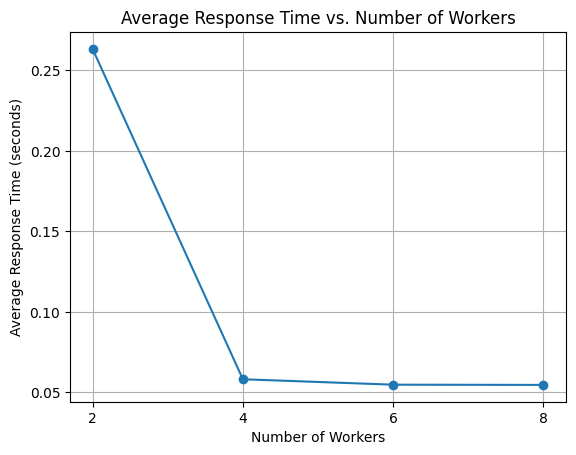

In [109]:
request_pattern = r'T(\d+) R\d+:(\d+\.\d+),.*?,(\d+\.\d+),(\d+\.\d+),(\d+\.\d+)'

def calculate_average_response_time(file_path):
	response_times = [] 

	with open(file_path, 'r') as file:
		for line in file:
			match = re.search(request_pattern, line)
			if match:
				completion_time = float(match.group(5))  # Completion time of request processing
				receipt_time = float(match.group(2))      # Receipt time of request
				response_time = completion_time - receipt_time  # Calculate response time
				response_times.append(response_time)

	# Calculate the average response time
	if response_times:
		average_response_time = sum(response_times) / len(response_times)
		return average_response_time
	return None

worker_counts = [2, 4, 6, 8]
average_response_times = []

for workers in worker_counts:
	file_path = f'./partC/server_log_w{workers}.txt' 
	avg_response_time = calculate_average_response_time(file_path)
	average_response_times.append(avg_response_time)
	print(f'Average response time with {workers} workers: {avg_response_time:.6f} seconds')

# Plotting the results
plt.plot(worker_counts, average_response_times, marker='o')
plt.title('Average Response Time vs. Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Average Response Time (seconds)')
plt.xticks(worker_counts)
plt.grid()
plt.show()



The large decrease in response time from 2 to 4 workers suggests that the system experienced a significant efficiency gain, indicating super-linear behavior in that range. The improvements from 4 to 6 and 6 to 8 workers show diminishing returns, which indicates that while the system still benefits from additional threads, the rate of improvement is not linear. 

The system exhibits super-linear characteristics at lower thread counts (particularly moving from 2 to 4), but as more threads are added (beyond 4), the improvements level off, and the system begins to exhibit diminishing returns.

-----
d)  Last but not least, let us study what happens to the rejection rate as more workers become available.

Run two cases and compare the output.

First, re-run or reuse the output from HW3 for the equivalent command:

`./server_multi -w 1 -q 10 2222 & ./client -a 18 -s 20 -n 1500 -d 0 2222`

Then, run and post-process the output of command:

`./server_multi -w 2 -q 10 2222 & ./client -a 18 -s 20 -n 1500 -d 0 2222`

Now look at the rejection rate and reason about the following: *if X is the rejection rate with 1 worker, then X/W is the rejection rate with W workers*. Is this true or not? Motivate your answer. You are not oblibged, but welcome to run additional relevant experiments to further sustain your conclusion.

In [110]:
def calculate_rejection_rate(log_file, total_requests=1500):
	with open(log_file, 'r') as file:
		content = file.read()

	completed_requests = re.findall(r'T\d+ R(\d+):', content)
	
	rejection_notices = re.findall(r'X\d+:', content)
	total_rejections = len(rejection_notices)

	rejection_rate = (total_rejections / total_requests) * 100 if total_requests > 0 else 0
	return rejection_rate, total_requests, total_rejections

log_file_1_worker = './partD/server_log_w1.txt' 
log_file_2_workers = './partD/server_log_w2.txt' 

# Calculate rejection rates
rejection_rate_1, total_requests_1, total_rejections_1 = calculate_rejection_rate(log_file_1_worker)
rejection_rate_2, total_requests_2, total_rejections_2 = calculate_rejection_rate(log_file_2_workers)

print(f"1 Worker:")
print(f"  Total Requests: {total_requests_1}")
print(f"  Total Rejections: {total_rejections_1}")
print(f"  Rejection Rate: {rejection_rate_1:.2f}%")

print(f"2 Workers:")
print(f"  Total Requests: {total_requests_2}")
print(f"  Total Rejections: {total_rejections_2}")
print(f"  Rejection Rate: {rejection_rate_2:.2f}%")

expected_rejection_rate_2 = rejection_rate_1 / 2  # Assuming ideal scaling
print(f"Expected rejection rate with 2 workers: {expected_rejection_rate_2:.2f}%")


1 Worker:
  Total Requests: 1500
  Total Rejections: 53
  Rejection Rate: 3.53%
2 Workers:
  Total Requests: 1500
  Total Rejections: 0
  Rejection Rate: 0.00%
Expected rejection rate with 2 workers: 1.77%


For 1 worker handling the requests, the rejection rate of 3.53% suggests that the worker was not able to keep up with the incoming request load. For 2 workers, the system was able to handle all incoming requests without rejecting any, which shows a improvement in throughput and efficiency. This illustrates how adding an extra worker can effectively balance the load. 

The expected rejection rate with 2 workers was 1.77%. The expected rejection rate is half of the 1-worker rejection rate, assuming ideal scaling. The actual rejection rate of 0% shows that the addition of the second worker led to better performance than expected. 